In [1]:
import sys
sys.path.extend(['..', '../bprime'])
    
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [120]:
import itertools
import numpy as np
import msprime
from bprime import tools
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold

In [405]:
TRAINING_DIR = '../data/slim_sims/segment/'

sim_params = dict(N=int, mu=float, h=float, s=float, rbp=float, recfrac=float, seglen=int)
X, y = tools.trees_to_training_data(TRAINING_DIR, params=sim_params, windows=[0, 100])
bl, B = y[:, 0], y[:, 1]

(array([ 15.,  24.,  43.,  49.,  59.,  83., 232., 475., 219.,  31.]),
 array([-2.08909062, -1.82408311, -1.55907561, -1.2940681 , -1.02906059,
        -0.76405309, -0.49904558, -0.23403807,  0.03096943,  0.29597694,
         0.56098445]),
 <BarContainer object of 10 artists>)

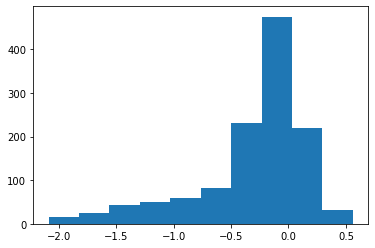

In [406]:
plt.hist(np.log10(B))

In [407]:
def data_transformer(X, transforms):
    Xtrans = np.empty_like(X)
    for i, func in enumerate(transforms.values()):
        if func is None:
            Xtrans[:, i] = X[:, i]
        else:
            Xtrans[:, i] = func(X[:, i])
    return Xtrans

In [408]:
Xt = data_transformer(X, dict(N=np.log10, mu=np.log10, h=None, s=np.log10, rbp=None, recfrac=np.log10, seglen=None))

In [497]:
model = RandomForestRegressor(n_estimators = 300)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, Xt, np.log10(B), scoring='explained_variance', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: 0.832 (0.029)


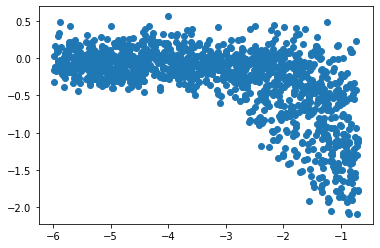

In [498]:
plt.scatter(Xt[:, 3], np.log10(B))

In [499]:
def predict_grid(params):
    grid_entries = []
    for param, specifier in params.items():
        if len(specifier) == 1:
            grid_entries.append(specifier)
        if len(specifier) == 3 or len(specifier) == 4:
            use_log10 = False
            if len(specifier) == 4:
                use_log10 = specifier == 'log10'
            lower, upper, size = specifier[:3]
            grid = np.linspace(lower, upper, size)
            if use_log10:
                grid = 10**grid
            grid_entries.append(grid)
    full_grid = []
    return np.stack((itertools.product(*grid_entries)))
        

predict_grid(dict(N=(2, 4, 10, 'log10'), 
                  mu=(5e-8, 5e-7, 10, 'log10'),
                  h=(0.5, ), 
                  s=(-6, np.log10(0.2), 10), 
                  rbp=(0.01/1e8, 30/1e8, 10), 
                  recfrac=(-8, np.log10(0.5)), 
                  seglen=(2, 4, 10, 'log10')))


/home/vsb/miniconda3/envs/bgcls/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[ 2.00000000e+00,  5.00000000e-08,  5.00000000e-01,
        -6.00000000e+00,  1.00000000e-10,  2.00000000e+00],
       [ 2.00000000e+00,  5.00000000e-08,  5.00000000e-01,
        -6.00000000e+00,  1.00000000e-10,  2.22222222e+00],
       [ 2.00000000e+00,  5.00000000e-08,  5.00000000e-01,
        -6.00000000e+00,  1.00000000e-10,  2.44444444e+00],
       ...,
       [ 4.00000000e+00,  5.00000000e-07,  5.00000000e-01,
        -6.98970004e-01,  3.00000000e-07,  3.55555556e+00],
       [ 4.00000000e+00,  5.00000000e-07,  5.00000000e-01,
        -6.98970004e-01,  3.00000000e-07,  3.77777778e+00],
       [ 4.00000000e+00,  5.00000000e-07,  5.00000000e-01,
        -6.98970004e-01,  3.00000000e-07,  4.00000000e+00]])

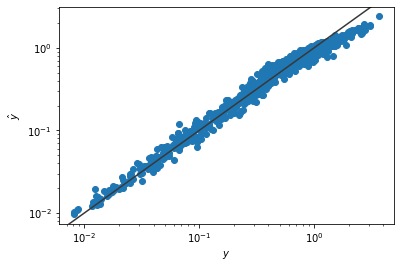

In [502]:
model.fit(Xt, np.log10(B))
yhat = model.predict(Xt)

fig, ax = plt.subplots()
ax.scatter(B, 10**yhat)
ax.set_xlabel('$y$')
ax.set_ylabel('$\hat{y}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.axline((0, 0), (1, 1), c='0.22')

In [503]:
def B_segment_lazy(rbp, L, s):
    """
    TODO check rbp = 0 case
    rt/ (b*(-1 + t) - t) * (b*(-1 + t) + r*(-1 + t) - t)
    """
    r = rbp*L
    a = -s*L # numerator -- ignores u
    b = (1-s)**2  # rf^2 terms
    c = 2*s*(1-s)+r*(1-s)**2 # rf terms
    d = s**2 + r*s*(1-s) # constant terms
    return a, b, c, d

@np.vectorize
def B_segment(mu, rf, rbp, L, s):
    a, b, c, d = B_segment_lazy(rbp, L, s)
    x = mu * a/(b*rf**2 + c*rf + d)
    return x

In [504]:
model.fit(Xt, np.log10(B))


/home/vsb/miniconda3/envs/bgcls/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


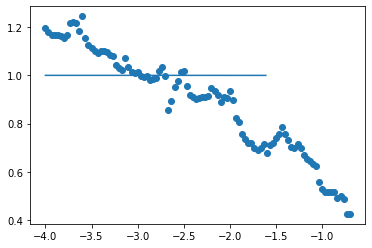

In [514]:
@np.vectorize
def bgs(mu, seglen, rbp, s):
    U = mu*seglen
    r = np.repeat(rbp, seglen)
    return np.exp(-U / np.sum((s*(s + (1-s)*r/s)**2)))


Xp = predict_grid(dict(N=(3, ), 
                  mu=(-7, ),
                  h=(0.5, ), 
                  s=(-4, np.log10(0.2), 100), 
                  #s=(-3, ), 
                  rbp=(1e-8, ), 
                  #recfrac=(-6, np.log10(0.1), 100),
                  recfrac=(-1, ),
                  seglen=(1000, )))

yhat = model.predict(Xp)

fig, ax = plt.subplots()
ax.scatter(Xp[:, 3], 10**yhat)
s = 10**np.linspace(-4, np.log(0.2), 100)
ax.plot(np.log10(s), np.exp(B_segment(mu=1e-7, rf=1e-1, rbp=1e-8, L=1000, s=s)))
#ax.set_ylim(0, 2)

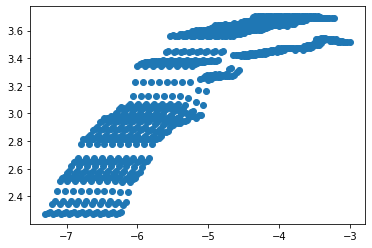

In [394]:
plt.scatter(np.log10(10**Xp[:, 1]/10**Xp[:, 3]), yhat)

(array([ 27., 121., 168., 113., 123., 108., 130., 141., 115.,  59.]),
 array([-6.49082323, -5.87435251, -5.25788178, -4.64141105, -4.02494032,
        -3.40846959, -2.79199887, -2.17552814, -1.55905741, -0.94258668,
        -0.32611596]),
 <BarContainer object of 10 artists>)

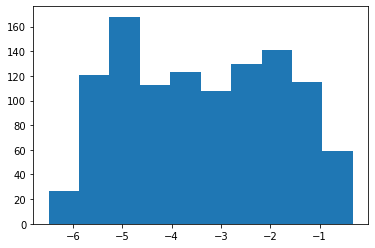

In [381]:
plt.hist(np.log10(X[:, 1]/X[:, 3]))

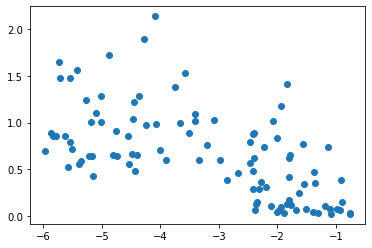

In [353]:
def nearest_data(X, y, points, k=100):
    if not isinstance(points, np.ndarray):
        points = np.array(points)
    dist = np.nansum((X - points[None, :])**2, axis=1)
    idx = np.argsort(dist)[:k]
    return X[idx, :], y[idx]

Xn, yn = nearest_data(Xt, pi, (3, -8, 0.5, np.nan, 1e-8, -8, 4))
plt.scatter(Xn[:, 3], yn)

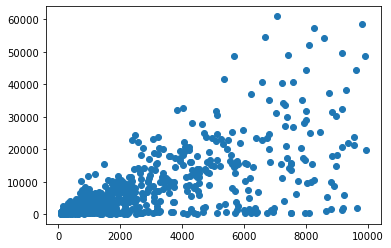

In [246]:
plt.scatter(X[:, 0], y)